## Imports, Classes, and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

## Data Preprocessing

In [2]:
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

np.random.seed(RANDOM_SEED)
mcu_subset = mcu_subset.reindex(np.random.permutation(mcu_subset.index))

mcu_subset.head()

,Unnamed: 0,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
3393,6565,STEVE ROGERS,"People are gonna die, Buck. I can't let that happen. Please, don't make me do this.",Captain America: The Winter Soldier,2014,17,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4909,11269,PETER PARKER,"Yeah, actually, I don’t intern for him anymore.",Spider-Man: Homecoming,2017,8,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4815,11073,PETER PARKER,Who are these guys? What can you tell me about the guy with the wings?,Spider-Man: Homecoming,2017,15,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3434,6641,STEVE ROGERS,You don't have to come with me.,Captain America: The Winter Soldier,2014,7,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96,143,TONY STARK,"Finally, I want: three pairs of tube socks, white, a toothbrush, protein powder, spices, sugar, five pounds of tea, cards. And a washing machine. Top load.",Iron Man,2008,29,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False


In [3]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1787
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,441
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [4]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X[0:10], y[0:10]

(array(["People are gonna die, Buck. I can't let that happen.  Please, don't make me do this.",
        'Yeah, actually, I don’t intern for him anymore.',
        'Who are these guys? What can you tell me about the guy with the wings?',
        "You don't have to come with me.",
        'Finally, I want: three pairs of tube socks, white, a toothbrush, protein powder, spices, sugar, five pounds of tea, cards.  And a washing machine.  Top load. ',
        "We're not salvaging anything. We're not just taking down the carriers, Nick, we're taking down SHIELD.",
        'The September Foundation.', "Kid, that's the wizard. Get on it.",
        'Okay, Clint.  Starting in three, two, one...',
        "You know damn well! You know damn well who!  She wouldn't want us to fight."],
       dtype='<U1388'),
 array(['STEVE ROGERS', 'PETER PARKER', 'PETER PARKER', 'STEVE ROGERS',
        'TONY STARK', 'STEVE ROGERS', 'TONY STARK', 'TONY STARK',
        'BRUCE BANNER', 'THOR'], dtype='<U16'))

## Models

In [5]:
cross_validator = StratifiedKFold(n_splits=100, random_state=RANDOM_SEED, shuffle=True)
hyperparameter_cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [6]:
stem_count_vectorizer = StemCountVectorizer(binary=False)
tfidf_transformer = TfidfTransformer()
nb_classifier = MultinomialNB(alpha=0.01)

In [7]:
count_params = {'vect__stop_words': [None, stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2)]}

tfidf_params = {'tfidf__use_idf': [True, False]}

nb_params = {'clf__fit_prior': [True, False]}

In [8]:
pipe13 = Pipeline([('vect', stem_count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters13 = {**count_params, **tfidf_params, **nb_params}

model13 = GridSearchCV(pipe13, parameters13, cv=hyperparameter_cross_validator, scoring=score_method, n_jobs=-1, verbose=6)

## Nested CV Balanced Accuracy

In [9]:
models = {"model 13": model13}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 115.3min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 310.2min remaining: 19.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 332.4min finished


,model 13
fold,
0,0.228333
1,0.293889
2,0.235556
3,0.321667
4,0.243889
5,0.285556
6,0.365000
7,0.313889
8,0.199444


## Confusion Matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 116.2min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 320.4min remaining: 20.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 349.3min finished


Balanced Accuracy: 0.29079971965938994
Balanced Accuracy: 0.29079971965939


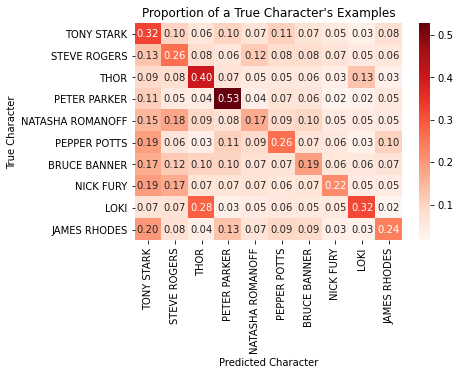

In [10]:
yhat = cross_val_predict(model13, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

## Recalls

In [11]:
recalls = pd.DataFrame(np.diagonal(normalized_conf_matrix.to_numpy()), index=main_characters, columns=["recall"])
recalls.sort_values(by="recall", ascending=False, inplace=True)
recalls.loc['mean'] = recalls.mean()

recalls.to_csv("./front_end/production_recalls.csv")

recalls

,recall
PETER PARKER,0.528131
THOR,0.398610
TONY STARK,0.324566
LOKI,0.318043
PEPPER POTTS,0.263039
STEVE ROGERS,0.262027
JAMES RHODES,0.238994
NICK FURY,0.218579
BRUCE BANNER,0.187335
NATASHA ROMANOFF,0.168675


## Prediction Table

In [12]:
prediction_table = pd.DataFrame({"line": X, "true character": y, "predicted character": yhat, "movie": mcu_subset['movie']})

prediction_table.sort_index(inplace=True)

dump(prediction_table, "./front_end/production_predictions.joblib")

prediction_table.head()

,line,true character,predicted character,movie
0,"Oh, I get it. You guys aren’t allowed to talk. Is that it? Are you not allowed to talk?",TONY STARK,PEPPER POTTS,Iron Man
1,Oh. I see. So it’s personal.,TONY STARK,TONY STARK,Iron Man
2,"Good God, you’re a woman. I, honestly, I couldn’t have called that. I would apologize, but isn’t that what we’re going for here? I saw you as a soldier first.",TONY STARK,STEVE ROGERS,Iron Man
3,Please.,TONY STARK,PETER PARKER,Iron Man
4,"Excellent question. Yes and no. March and I had a schedule conflict but, thankfully, the Christmas cover was twins. Anyone else? You, with the hand up.",TONY STARK,TONY STARK,Iron Man


## Learning Curve

In [13]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=6)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return

[learning_curve] Training set sizes: [ 644 2093 3542 4991 6441]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/usr/local/anaconda3/2020.07/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  81 out of 500 | elapsed: 174.6min remaining: 903.0min
[Parallel(n_jobs=-1)]: Done 165 out of 500 | elapsed: 347.2min remaining: 704.9min
[Parallel(n_jobs=-1)]: Done 249 out of 500 | elapsed: 514.6min remaining: 518.7min
[Parallel(n_jobs=-1)]: Done 333 out of 500 | elapsed: 681.0min remaining: 341.5min
[Parallel(n_jobs=-1)]: Done 417 out of 500 | elapsed: 850.8min remaining: 169.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 1022.6min finished


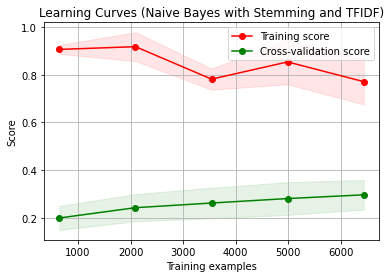

In [14]:
title = "Learning Curves (Naive Bayes with Stemming and TFIDF)"

plot_learning_curve(model13, title, X, y, cv=cross_validator)

## Peformance as a function of words

Do examples with more words (longer examples) get classified correctly more often?

In [15]:
prediction_table['words'] = prediction_table['line'].str.split(" ").str.len()
prediction_table['correct_prediction'] = (prediction_table['true character'] == prediction_table['predicted character']).astype('int64')

In [16]:
reg_model = smf.ols('prediction_table["correct_prediction"] ~ prediction_table["words"]', data=prediction_table).fit()

reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     prediction_table["correct_prediction"]   R-squared:                       0.018
Model:                                                OLS   Adj. R-squared:                  0.018
Method:                                     Least Squares   F-statistic:                     118.2
Date:                                    Sat, 09 Jan 2021   Prob (F-statistic):           2.73e-27
Time:                                            21:29:19   Log-Likelihood:                -4143.2
No. Observations:                                    6507   AIC:                             8290.
Df Residuals:                                        6505   BIC:                             8304.
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2578      0.007     35.356      0.000       0.244       0.272
prediction_table["words"]     0.0046      0.000     10.871      0.000       0.004       0.005
==============================================================================
Omnibus:                     9101.067   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1153.214
Skew:                           0.824   Prob(JB):                    3.83e-251
Kurtosis:                       1.759   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'accuracy')

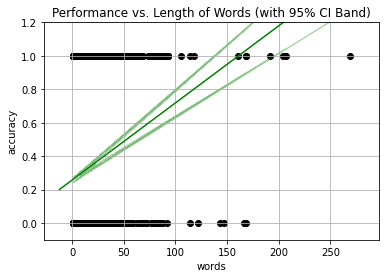

In [17]:
def abline(intercept, slope, col):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color=col)
    

plt.scatter(x = prediction_table['words'].to_numpy(),
            y = prediction_table['correct_prediction'].to_numpy(),
            color='black')

abline(reg_model.params[0], reg_model.params[1], 'green')

conf_pred_intervals = reg_model.get_prediction(prediction_table['words']).summary_frame()

plt.fill_between(prediction_table['words'].to_numpy(), conf_pred_intervals['mean_ci_lower'], conf_pred_intervals['mean_ci_upper'], alpha=0.3, color='green')

plt.grid()
plt.ylim(-0.1,1.2)
plt.title('Performance vs. Length of Words (with 95% CI Band)')
plt.xlabel('words')
plt.ylabel('accuracy')

Using a t test and a confidence level of 95% ($\alpha=0.05$), we **reject** the null hypothesis that there is no relationship between the number of words in an example and our model's performance on it ($t=10.871$, $p<0.001$).

Having a longer line means that the change of a correct prediction increases.

## Export Model

In [18]:
model13.fit(X,y)
prod_model = model13.best_estimator_
dump(prod_model, './front_end/production_model.joblib')

prod_model

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  71 out of  80 | elapsed:  6.0min remaining:   45.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.6min finished


Pipeline(steps=[('vect', StemCountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

## Character Correlations

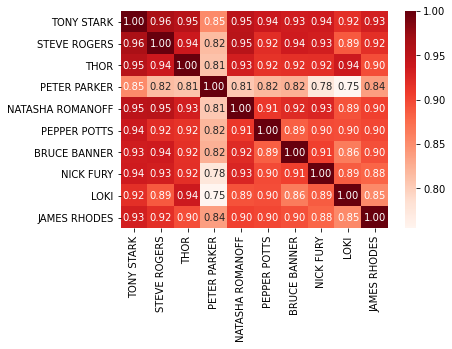

In [19]:
vect = prod_model.named_steps['vect']
main_characters = mcu_subset['character'].value_counts().index.to_numpy()

character_correlations = np.zeros(shape=(len(main_characters), len(main_characters)))

for i in range(0, len(main_characters)):
    for j in range(i, len(main_characters)):
        vector_i = np.sum(vect.transform(mcu_subset[mcu_subset['character'] == main_characters[i]]['line'].to_numpy()).toarray(), axis=0)
        vector_j = np.sum(vect.transform(mcu_subset[mcu_subset['character'] == main_characters[j]]['line'].to_numpy()).toarray(), axis=0)
            
        r = stats.stats.pearsonr(vector_i, vector_j)[0]
        character_correlations[i][j] = r
        character_correlations[j][i] = r

character_correlations = pd.DataFrame(character_correlations, columns=main_characters, index=main_characters)

dump(character_correlations, "./front_end/character_correlations.joblib")

sns.heatmap(character_correlations, annot=True, fmt='.2f', cmap=plt.cm.Reds)